# <center><font color="red">Retinopathy-Detection</center>

# **PROBLEM STATEMENT**
- To prepare a complete data analysis and deep learning-based classification report on the given retinal fundus image dataset for retinopathy detection.

- To build and evaluate a Convolutional Neural Network (CNN) model that classifies retina scan images into their respective retinopathy severity levels, supporting early diagnosis and treatment planning for diabetic retinopathy and related eye disorders.

# **DOMAIN ANALYSIS AND DATA INFORMATION**
- Retinopathy is a condition involving damage to the retina, the light-sensitive tissue at the back of the eye. It is most often caused by diabetes, known as **Diabetic Retinopathy**, and can result in permanent vision loss or blindness if not treated promptly.

- Automated retinal image analysis through deep learning and computer vision provides an effective way to assist ophthalmologists in early detection and grading of retinopathy. This can improve patient outcomes, reduce manual screening workload, and support large-scale health screening programs.

- Key challenges include variations in image brightness, the presence of microaneurysms, hemorrhages, exudates, and other retinal lesions that may appear subtle in early stages but must be accurately detected.

---

## **CLASSES**
- The dataset is categorized into three classes, each representing a different severity of retinopathy.

- Total Classes: **3**

- Class Definitions:

     - **Class 1: No or Mild Retinopathy** – healthy retina or early signs with very subtle features.

     - **Class 2: Moderate Retinopathy** – visible signs like microaneurysms, exudates, and small hemorrhages.

     - **Class 3: Severe Retinopathy** – prominent lesions, widespread hemorrhages, and potential risk of vision loss.

---

## **DATASET DETAILS**
The dataset is curated to develop a deep learning model for classifying retinopathy from retinal fundus images. It includes image files organized in a structured format and a CSV file containing metadata for efficient preprocessing and label mapping.

####  **IMAGE FOLDER**
- Contains **1,764** retinal images in .jpg format.
  
- Images are not divided into subfolders but are labeled using an accompanying **CSV file**.
  
- Each image corresponds to one of three categories indicating different types or severities of retinopathy.

#### **CSV FILE**
- File name: **data_all.csv**

- Shape: 1764 rows × 3 columns

- Columns:

   - **Unnamed: 0**: Index column (can be ignored)

   - **file**: Filename of the retinal image

   - **cat**: Category label (1, 2, or 3) used to map each image to its respective class and facilitate training/validation/test splitting.

# 1. IMPORTING LIBRARIES

In [ ]:
import os
import zipfile
import cv2
import shutil
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 2. EXTRACTING DATASET FROM ZIP FILE

In [ ]:
with zipfile.ZipFile(r"D:\DATAMITES\AI CLIENT\RETINOPATHY\ratinopathy.zip") as zip_ref:
    zip_ref.extractall(r"D:\DATAMITES\AI CLIENT\RETINOPATHY")

# 3. BASIC CHECKS

In [ ]:
CSV_PATH = r"D:\DATAMITES\AI CLIENT\RETINOPATHY\data_all.csv"
IMAGE_DIR = r"D:\DATAMITES\AI CLIENT\RETINOPATHY\images"
OUTPUT_DIR = r"D:\DATAMITES\AI CLIENT\RETINOPATHY\dataset"

### 3.1. CSV FILE

**FILE NAME = data_all.csv**

In [ ]:
# Loading the csv file
data = pd.read_csv(CSV_PATH)

In [ ]:
# Visualizing the first 10 rows of the data
data.head(10)

,Unnamed: 0,file,cat
0,0,o_c1t10003118.jpg,1
1,1,o_c1t1003016260.jpg,1
2,2,o_c1t1004522299.jpg,1
3,3,o_c1t1008823172.jpg,1
4,4,o_c1t1011431188.jpg,1
5,5,o_c1t10124484.jpg,1
6,6,o_c1t1017812937.jpg,1
7,7,o_c1t1019068.jpg,1
8,8,o_c1t1019917974.jpg,1
9,9,o_c1t102131695.jpg,1


In [ ]:
# Visualizing the last 10 rows of the data
data.tail(10)

,Unnamed: 0,file,cat
1754,1754,o_c3t97463648.jpg,3
1755,1755,o_c3t978617134.jpg,3
1756,1756,o_c3t97871822.jpg,3
1757,1757,o_c3t983521391.jpg,3
1758,1758,o_c3t989512823.jpg,3
1759,1759,o_c3t992926103.jpg,3
1760,1760,o_c3t993929121.jpg,3
1761,1761,o_c3t994023728.jpg,3
1762,1762,o_c3t996710741.jpg,3
1763,1763,o_c3t999411633.jpg,3


In [ ]:
# Checking the number of rows and columns of the data
data.shape

(1764, 3)

In [ ]:
# Checking the index of the data
data.index

RangeIndex(start=0, stop=1764, step=1)

In [ ]:
# Checking the column names of the data
data.columns

Index(['Unnamed: 0', 'file', 'cat'], dtype='object')

In [ ]:
# Removing unnecessary column (Unnamed: 0)
data.drop(columns="Unnamed: 0", inplace=True)

In [ ]:
# Checking the duplicates
data.duplicated().sum()

0

In [ ]:
# Checking the statistical information in a data
data.describe()

,cat
count,1764.000000
mean,1.757937
std,0.786889
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


In [ ]:
# Checking the unique value in "cat" column
num_classes = data["cat"].nunique()
print(f"There are {num_classes} unique values in cat column")
print(f"Unique values are: {data['cat'].unique()}")

There are 3 unique values in cat column
Unique values are: [1 2 3]


In [ ]:
# Checking the value counts in "cat" column
data["cat"].value_counts()

cat
1    811
2    569
3    384
Name: count, dtype: int64

### 3.2. IMAGE DATA

In [ ]:
# Checking the total images
print("Total images:", len(os.listdir(r"D:\DATAMITES\AI CLIENT\RETINOPATHY\images")))

Total images: 1764


In [ ]:
# Checking the Image Extensions of All Images
extensions = set()
for file in os.listdir(IMAGE_DIR):
    ext = os.path.splitext(file)[1]
    extensions.add(ext.lower())

print("Image extensions of all images:", extensions)

Image extensions of all images: {'.jpg'}


# 4. VISUALIZING ALL THE CLASSES (3 CLASSES)

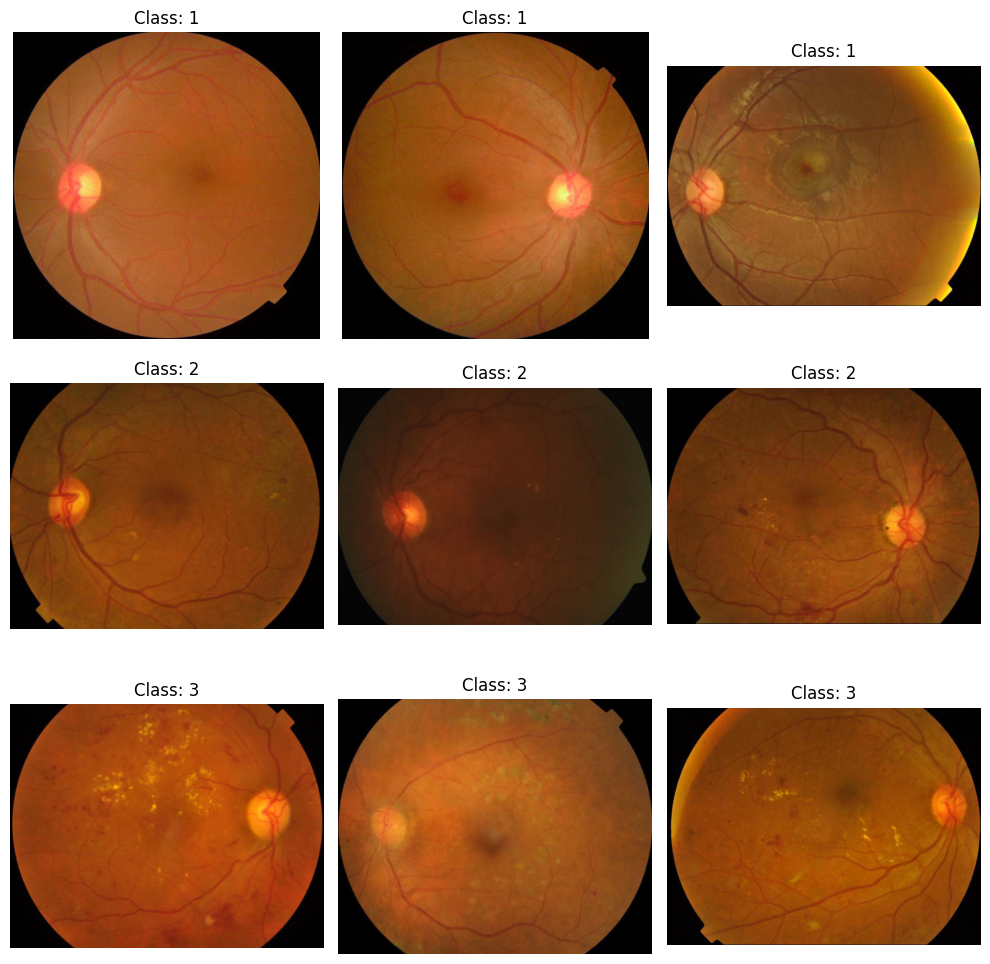

In [ ]:
plt.figure(figsize=(10, 10))
i = 1

for cls in [1, 2, 3]:
    class_images = data[data['cat'] == cls].head(3)
    for _, row in class_images.iterrows():
        img_path = os.path.join(IMAGE_DIR, row['file'])
        img = plt.imread(img_path)

        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Class: {cls}")
        i += 1

plt.tight_layout()
plt.show()

## INSIGHT
- **In the above visualization, all the images appear in different dimensions. To ensure consistency, all images in the dataset must be resized to a fixed dimension, as Convolutional Neural Networks (CNNs) require uniform input shapes for effective training and to prevent shape mismatch errors.**

# 5. SPLITTING AND COPYING FILES

### 5.1. TRAIN, VALIDATION AND TEST SPLIT

```
Training Set   : 70% of the data
Validation Set : 18% of the data
Test Set       : 12% of the data
```

In [ ]:
# Splitting the dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['cat'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.6, stratify=temp_data['cat'], random_state=42)

In [ ]:
# Organizing the Dataset Splits
splits = {'train': train_data, 'val': val_data, 'test': test_data}

In [ ]:
# Creating Directory Structure for Each Split and Class
for split_name, split_df in splits.items():
    for label in sorted(split_df['cat'].unique()):
        split_dir = os.path.join(OUTPUT_DIR, split_name, str(label))
        os.makedirs(split_dir, exist_ok=True)

### 5.2. COPYING IMAGES

In [ ]:
# Creating Function to Copy Images into Respective Directories Based on Dataset Split and Class
def copy_images(split_name, split_df):
    for index in tqdm(range(len(split_df)), desc=f"Copying {split_name}"):
        row = split_df.iloc[index]
        filename = row['file']
        label = row['cat']

        src = Path(IMAGE_DIR) / filename
        dst_dir = Path(OUTPUT_DIR) / split_name / str(label)
        dst = dst_dir / filename

        try:
            dst_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
        except Exception as e:
            print(f"[ERROR] Could not copy {src} → {dst}: {e}")

In [ ]:
# Executing Image Copying for Train, Validation, and Test Splits
copy_images('train', train_data)
copy_images('val', val_data)
copy_images('test', test_data)

Copying test: 100%|█████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 429.68it/s]


### 5.3. IMAGE COUNTS

#### TRAIN

In [ ]:
train_dir = 'dataset/train'
count = 0

print("Images per class in train folder:\n")
for class_folder in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        count += num_images
        print(f"Class {class_folder}: {num_images} images")

print(f"\nTotal images in train: {count}")

Images per class in train folder:

Class 1: 567 images
Class 2: 398 images
Class 3: 269 images

Total images in train: 1234


#### VALIDATION

In [ ]:
val_dir = 'dataset/val'
count = 0

print("Images per class in val folder:\n")

for class_folder in sorted(os.listdir(val_dir)):
    class_path = os.path.join(val_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        count += num_images
        print(f"Class {class_folder}: {num_images} images")

print(f"\nTotal images in val: {count}")

Images per class in val folder:

Class 1: 98 images
Class 2: 68 images
Class 3: 46 images

Total images in val: 212


#### TEST

In [ ]:
test_dir = 'dataset/test'
count = 0

print("Images per class in test folder:\n")

for class_folder in sorted(os.listdir(test_dir)):
    class_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        count += num_images
        print(f"Class {class_folder}: {num_images} images")

print(f"\nTotal images in test: {count}")

Images per class in test folder:

Class 1: 146 images
Class 2: 103 images
Class 3: 69 images

Total images in test: 318


# 6. DATA PREPROCESSING

### 6.1. RESIZING IMAGES TO A UNIFORM SHAPE (224x224)

In [ ]:
img_size = 224
labels = os.listdir(train_dir)

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img))
            if img_arr is None:
                continue
            img_arr = img_arr[..., ::-1]  # BGR to RGB
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
    return np.array(data, dtype="object")

### 6.2. LOADING AND VERIFYING DATA

In [ ]:
train = get_data(r"D:\DATAMITES\AI CLIENT\RETINOPATHY\dataset\train")
print(f"Total training images: {len(train_data)}")

Total training images: 1234


In [ ]:
test = get_data(r"D:\DATAMITES\AI CLIENT\RETINOPATHY\dataset\test")
print(f"Total testing images: {len(test_data)}")

Total testing images: 318


In [ ]:
val = get_data(r"D:\DATAMITES\AI CLIENT\RETINOPATHY\dataset\val")
print(f"Total validating images: {len(val_data)}")

Total validating images: 212


### 6.3. SEPARATING FEATURES AND LABELS

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(np.array(feature))
  y_train.append(int(label))

for feature, label in test:
    x_test.append(np.array(feature))
    y_test.append(int(label))

for feature, label in val:
  x_val.append(np.array(feature))
  y_val.append(int(label))

### 6.4. NORMALIZING IMAGE DATA

In [ ]:
x_train = np.array(x_train).astype("float32") / 255.0
x_val   = np.array(x_val).astype("float32") / 255.0
x_test  = np.array(x_test).astype("float32") / 255.0

### 6.5. CONVERTING LABELS TO NUMPY ARRAYS

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# 7. MODEL CREATION

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(3, activation='softmax'))
model.summary(line_length=140)

Model: "sequential"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 conv2d (Conv2D)                                               (None, 220, 220, 32)                                    2432                 
                                                                                                                                            
 conv2d_1 (Conv2D)                                             (None, 216, 216, 32)                                    25632                
                                                                                                                                            
 max_pooling2d (MaxPooling2D)                                  (None, 108, 108, 32)                                    0              

# 8. MODEL COMPILATION AND FITTING

In [ ]:
model.compile(optimizer = "rmsprop" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(x_train,y_train, batch_size = 16 ,epochs = 30, validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/30
78/78 [==============================] - 19s 89ms/step - loss: 2.9673 - accuracy: 0.6053 - val_loss: 0.6952 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 2/30
78/78 [==============================] - 6s 75ms/step - loss: 0.6907 - accuracy: 0.6799 - val_loss: 0.7271 - val_accuracy: 0.7123 - lr: 0.0010
Epoch 3/30
78/78 [==============================] - 6s 75ms/step - loss: 0.6680 - accuracy: 0.6961 - val_loss: 0.7126 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 4/30
78/78 [==============================] - 6s 77ms/step - loss: 0.6830 - accuracy: 0.7010 - val_loss: 0.6192 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 5/30
78/78 [==============================] - 6s 75ms/step - loss: 0.6268 - accuracy: 0.7269 - val_loss: 0.7957 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 6/30
78/78 [==============================] - 6s 75ms/step - loss: 0.6560 - accuracy: 0.7050 - val_loss: 0.6610 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/30
78/78 [==============================] - 6s 75ms/step - loss: 0.

# 9. VISUALIZING PLOTS

### 9.1. ACCURACY PLOT

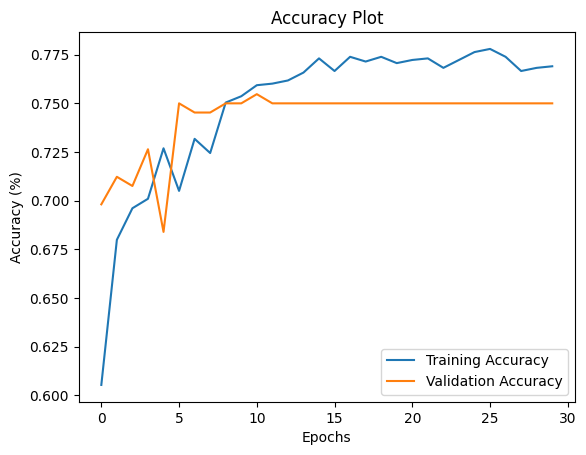

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

### 9.2. LOSS PLOT

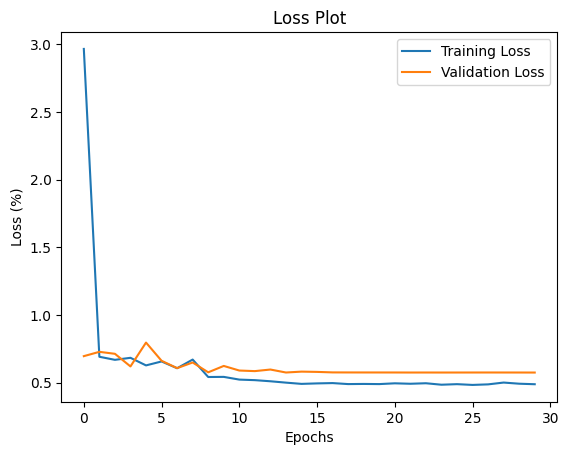

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

# 10. MODEL EVALUATION

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Loss of the model is - " , loss)
print("\n")
print("Accuracy of the model is - " , accuracy)

Loss of the model is -  0.5788469910621643


Accuracy of the model is -  0.7358490824699402


In [ ]:
predictions = model.predict(x_test)

predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

10/10 [==============================] - 1s 31ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 0 1 1 1 1 0 1 1 1 2 1 1 2 1 2 1
 0 1 1 1 2 1 1 1 1 1 0 2 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 2 1 1 2 1 1 1
 0 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 2 1 1 1 1 2 1 1 0 1 1 1 2 1 1
 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 2 2 1]


# 11. CONFUSION MATRIX

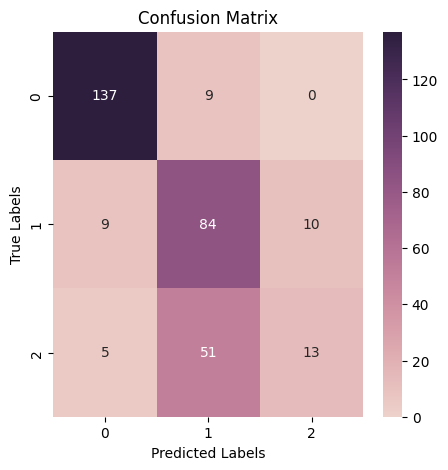

In [ ]:
cm = confusion_matrix(y_test, predicted_classes)
df_cm = pd.DataFrame(cm, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])

plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True),fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 12. CLASSIFICATION REPORT

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, predicted_classes, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.9073    0.9384    0.9226       146
           1     0.5833    0.8155    0.6802       103
           2     0.5652    0.1884    0.2826        69

    accuracy                         0.7358       318
   macro avg     0.6853    0.6474    0.6284       318
weighted avg     0.7281    0.7358    0.7052       318



# 13. TEST-IMAGE PREDICTIONS (GREEN: CORRECT, RED: INCORRECT)

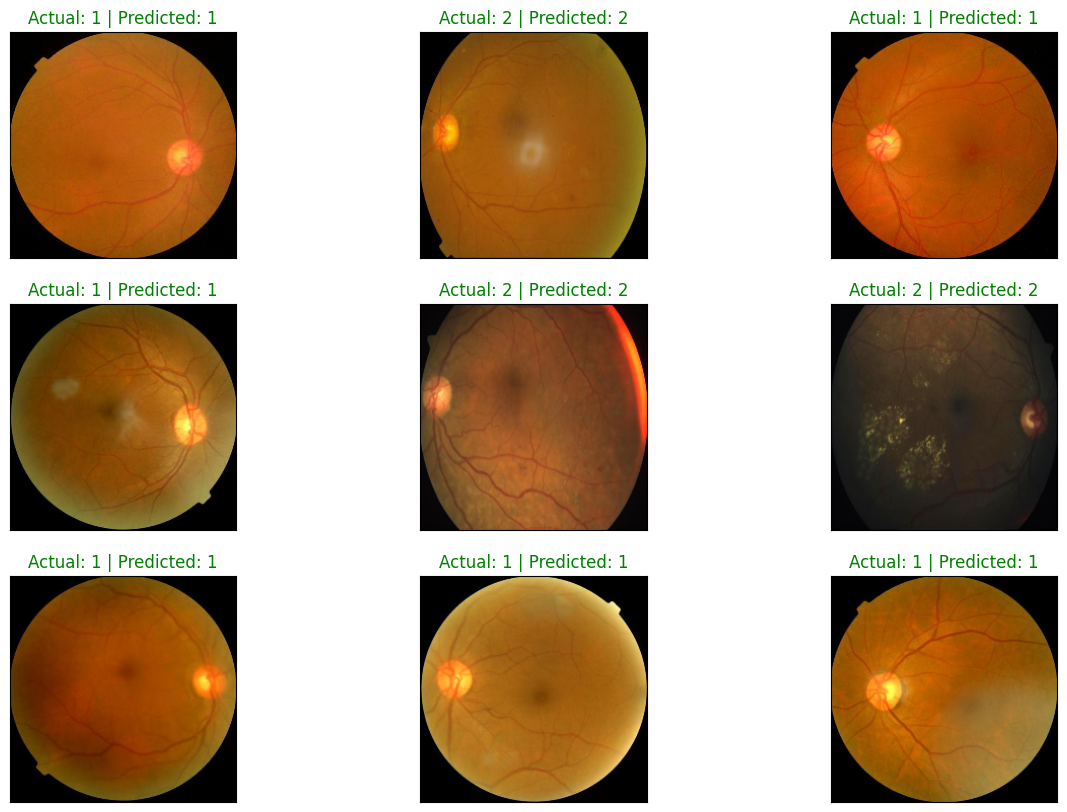

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=9, replace=False)):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    image = x_test[idx].squeeze()
    ax.imshow(image, cmap='gray')

    pred_label = predicted_classes[idx]
    true_label = y_test[idx]

    ax.set_title(f"Actual: {labels[true_label]} | Predicted: {labels[pred_label]}",
                 color=("green" if pred_label == true_label else "red"))

# TRANSFER LEARNING

### PRE-TRAINED MODEL: **MobileNetV2**

## 1. TRANSFER LEARNING MODEL CONSTRUCTION

In [ ]:
mobilenetv2_model = Sequential([
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False,
        input_shape=(224, 224, 3),
        name='mobilenet_v2_feature_extractor'
    ),
    layers.Dense(3, activation='softmax', name='output_layer')
])

## 2. MODEL COMPILATION AND FITTING

In [ ]:
mobilenetv2_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['acc'])

history_ptm = mobilenetv2_model.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=25)

Epoch 1/25
39/39 [==============================] - 8s 64ms/step - loss: 0.9423 - acc: 0.5624 - val_loss: 0.6340 - val_acc: 0.7170
Epoch 2/25
39/39 [==============================] - 1s 35ms/step - loss: 0.5136 - acc: 0.7869 - val_loss: 0.5329 - val_acc: 0.8019
Epoch 3/25
39/39 [==============================] - 1s 35ms/step - loss: 0.4422 - acc: 0.8120 - val_loss: 0.4835 - val_acc: 0.7736
Epoch 4/25
39/39 [==============================] - 1s 29ms/step - loss: 0.4025 - acc: 0.8412 - val_loss: 0.4592 - val_acc: 0.8255
Epoch 5/25
39/39 [==============================] - 1s 29ms/step - loss: 0.3808 - acc: 0.8558 - val_loss: 0.4528 - val_acc: 0.8349
Epoch 6/25
39/39 [==============================] - 1s 29ms/step - loss: 0.3700 - acc: 0.8444 - val_loss: 0.4302 - val_acc: 0.8208
Epoch 7/25
39/39 [==============================] - 1s 29ms/step - loss: 0.3539 - acc: 0.8639 - val_loss: 0.4148 - val_acc: 0.8255
Epoch 8/25
39/39 [==============================] - 1s 29ms/step - loss: 0.3365 - a

## 3. VISUALIZING PLOTS

#### 3.1. ACCURACY PLOT

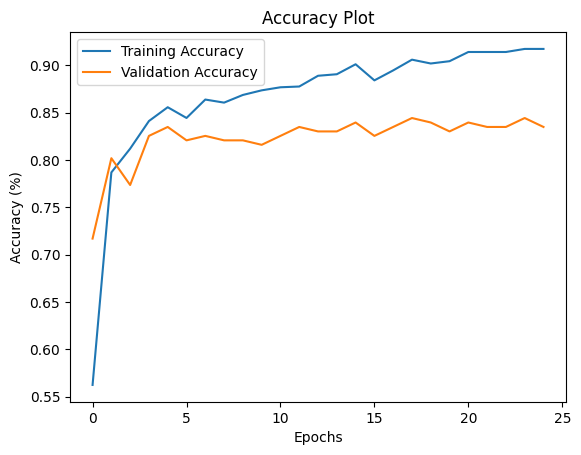

In [ ]:
plt.figure()
plt.plot(history_ptm.history['acc'], label = "Training Accuracy")
plt.plot(history_ptm.history['val_acc'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

#### 3.2. LOSS PLOT

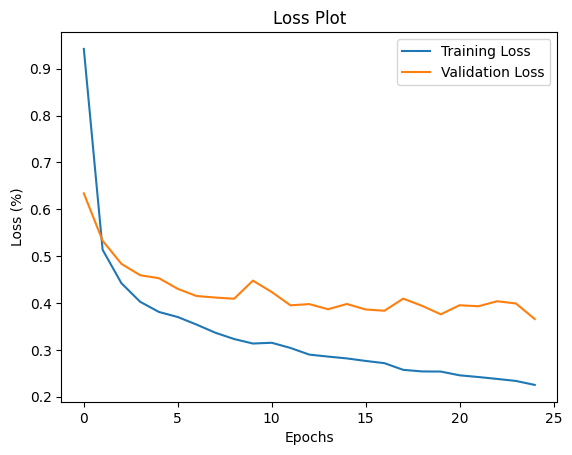

In [ ]:
plt.figure()
plt.plot(history_ptm.history['loss'], label = "Training Loss")
plt.plot(history_ptm.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

## 4. MODEL EVALUATION

In [ ]:
loss_mobilenetv2, accuracy_mobilenetv2 = mobilenetv2_model.evaluate(x_test, y_test, verbose=0)
print("Loss of the model is - " , loss_mobilenetv2)
print("\n")
print("Accuracy of the model is - " , accuracy_mobilenetv2)

Loss of the model is -  0.40675589442253113


Accuracy of the model is -  0.8427672982215881


In [ ]:
predictions_ptm = mobilenetv2_model.predict(x_test)

predicted_classes_ptm = predictions_ptm.argmax(axis=1)
print(predicted_classes_ptm)

10/10 [==============================] - 1s 49ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 2 1 1 2 2 1 1 1 1 1 2 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 2 1 1 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1 2 1
 2 2 2 2 0 2 1 1 2 2 2 1 2 1 2 1 2 2 2 2 2 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2
 2 1 2 2 1 1 2 1 2 2 1 1 2 2 1 1 2 1 1 1 2 2]


## 5. CONFUSION MATRIX

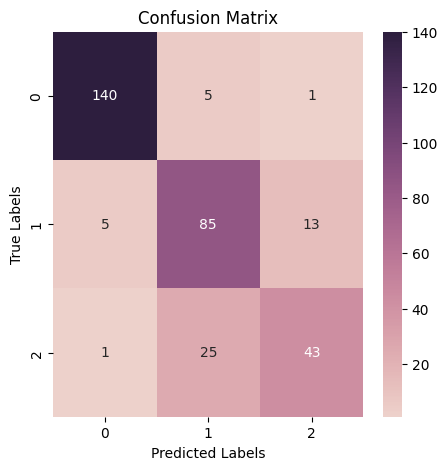

In [ ]:
cm_ptm = confusion_matrix(y_test, predicted_classes_ptm)
df_cm_ptm = pd.DataFrame(cm_ptm, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])

plt.figure(figsize=(5, 5))
sns.heatmap(df_cm_ptm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True),fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 6. CLASSIFICATION REPORT

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, predicted_classes_ptm, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.9589    0.9589    0.9589       146
           1     0.7391    0.8252    0.7798       103
           2     0.7544    0.6232    0.6825        69

    accuracy                         0.8428       318
   macro avg     0.8175    0.8024    0.8071       318
weighted avg     0.8433    0.8428    0.8409       318



## 7. TEST-IMAGE PREDICTIONS (GREEN: CORRECT, RED: INCORRECT)

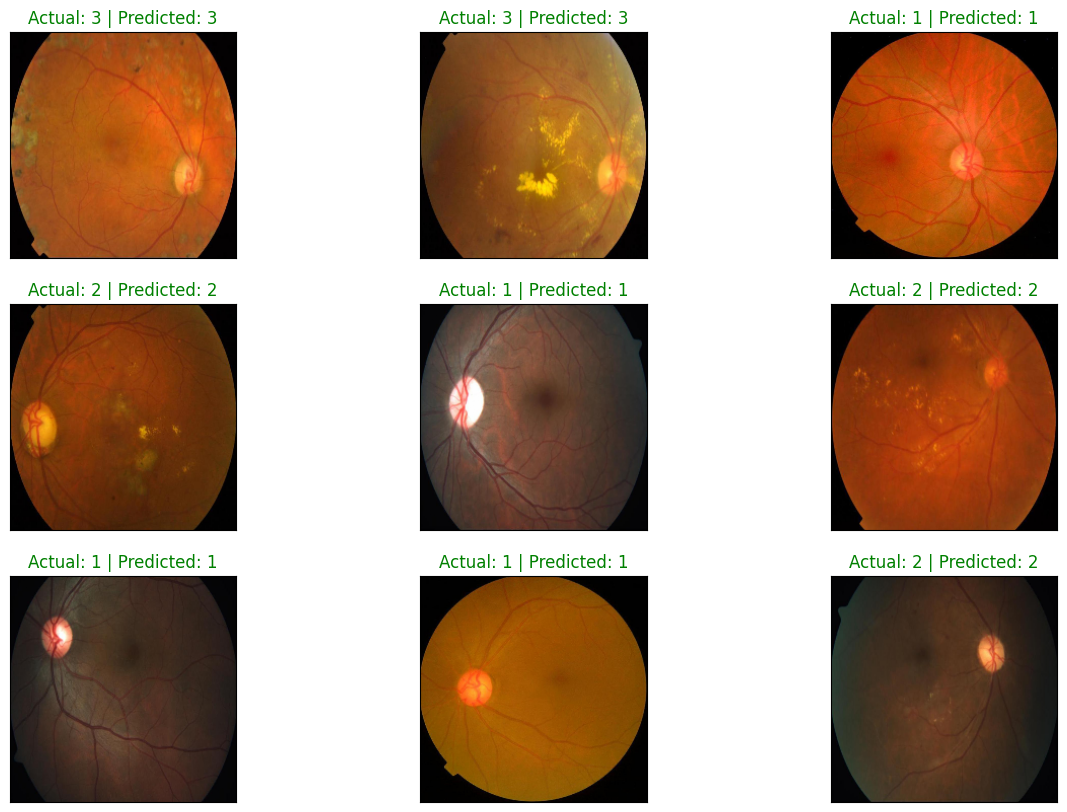

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=9, replace=False)):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    image = x_test[idx].squeeze()
    ax.imshow(image, cmap='gray')

    pred_label = predicted_classes_ptm[idx]
    true_label = y_test[idx]

    ax.set_title(f"Actual: {labels[true_label]} | Predicted: {labels[pred_label]}",
                 color=("green" if pred_label == true_label else "red"))

# ACCURACY RESULTS

In [ ]:
print(f"The accuracy of the CNN model is {accuracy:.2f}")
print(f"The accuracy of the MobileNetV2 model is {accuracy_mobilenetv2:.2f}")

The accuracy of the CNN model is 0.74
The accuracy of the MobileNetV2 model is 0.84


# LOSS RESULTS

In [ ]:
print(f"The loss of the CNN model is {loss:.2f}")
print(f"The loss of the MobileNetV2 model is {loss_mobilenetv2:.2f}")

The loss of the CNN model is 0.58
The loss of the MobileNetV2 model is 0.41


# CONCLUSION

- The CNN model achieved an accuracy of **74%**, while the MobileNetV2-based transfer learning model achieved a higher accuracy of **84%**. This difference demonstrates the effectiveness of transfer learning, where pretrained models like MobileNetV2 leverage knowledge gained from large-scale datasets to improve performance on specialized tasks with limited data.

- The pretrained **MobileNetV2 model** was able to extract more abstract and transferable features, leading to better generalization and reduced overfitting. In contrast, the CNN model trained from scratch lacked these pre-learned feature representations, resulting in lower performance despite similar preprocessing.

- These results confirm that using pretrained models is not only efficient in terms of time and computational resources but also highly effective for improving accuracy and reliability, particularly in healthcare deep learning scenarios where labeled data is often scarce and domain expertise is critica

# CHALLENGES FACED

- Insufficient data
- Complexity of the model
- High computational time
- Hardware limitations